In [1]:
using Turing
using DataFrames
using CSV
using Random
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using StatsPlots
using StatsBase
using FreqTables
using Logging

default(label=false)
Logging.disable_logging(Logging.Warn);

┌ Info: Precompiling StatisticalRethinking [2d09df54-9d0f-5258-8220-54c2a3d4fbee]
└ @ Base loading.jl:1342
┌ Info: Precompiling StatisticalRethinkingPlots [e1a513d0-d9d9-49ff-a6dd-9d2e9db473da]
└ @ Base loading.jl:1342


# 11.1 Binomial regression

Code 11.1

In [2]:
d = DataFrame(CSV.File("data/chimpanzees.csv", delim=';'));

Code 11.2

In [3]:
d[!,:treatment] = 1 .+ d.prosoc_left .+ 2*d.condition;

Code 11.3

In [4]:
println(freqtable(d, :treatment, :prosoc_left, subset=d.condition .== 0))
println(freqtable(d, :treatment, :prosoc_left, subset=d.condition .== 1))

2×2 Named Matrix{Int64}
treatment ╲ prosoc_left │   0    1
────────────────────────┼─────────
1                       │ 126    0
2                       │   0  126
2×2 Named Matrix{Int64}
treatment ╲ prosoc_left │   0    1
────────────────────────┼─────────
3                       │ 126    0
4                       │   0  126


Code 11.4

In [5]:
@model function m11_1(pulled_left)
    a ~ Normal(0, 10)
    p = logistic(a)     # inverse of the `logit` function
    pulled_left ~ Binomial(1, p)
end

m11_1 (generic function with 2 methods)

Code 11.5

In [6]:
Random.seed!(1999)
prior_chain = sample(m11_1(d.pulled_left), Prior(), 10000)
prior = DataFrame(prior_chain);

Code 11.6

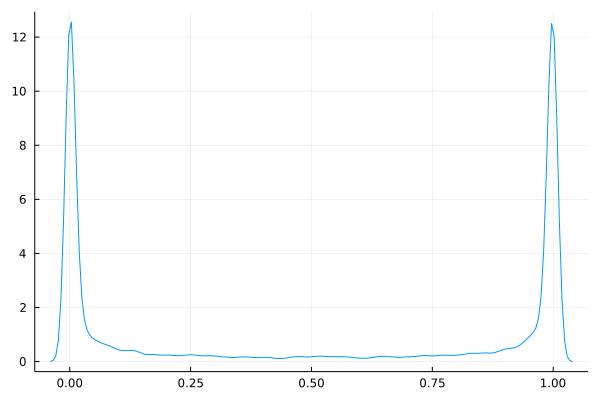

In [7]:
p = logistic.(prior.a)
density(p, bandwidth=0.01)

Code 11.7

In [8]:
@model function m11_2(pulled_left, treatment)
    a ~ Normal(0, 1.5)
    treat_levels = length(levels(d.treatment))
    b ~ MvNormal(zeros(treat_levels), 10)
    
    p = @. logistic(a + b[treatment])
    for i ∈ eachindex(pulled_left)
        pulled_left[i] ~ Binomial(1, p[i])
    end
end

Random.seed!(1999)
prior_chain = sample(m11_2(d.pulled_left, d.treatment), Prior(), 10000)
prior = DataFrame(prior_chain);

f = i -> @. logistic(prior.a + prior[!,"b[$i]"])
p = map(f, 1:4);

Code 11.8

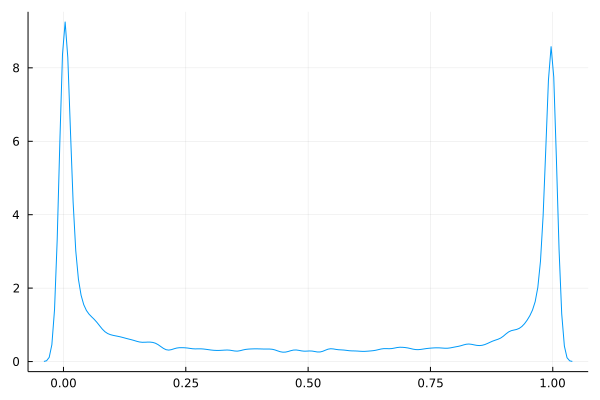

In [9]:
density(abs.(p[1] .- p[2]), bandwidth=0.01)

Code 11.9

In [10]:
@model function m11_3(pulled_left, treatment)
    a ~ Normal(0, 1.5)
    treat_levels = length(levels(treatment))
    b ~ MvNormal(zeros(treat_levels), 0.5)
    
    p = @. logistic(a + b[treatment])
    for i ∈ eachindex(pulled_left)
        pulled_left[i] ~ Binomial(1, p[i])
    end
end

Random.seed!(1999)
prior_chain = sample(m11_3(d.pulled_left, d.treatment), Prior(), 10000)
prior = DataFrame(prior_chain);

f = i -> @. logistic(prior.a + prior[!,"b[$i]"])
p = map(f, 1:4);

mean(abs.(p[1] .- p[2]))

0.09924607142428958

Code 11.10

In [11]:
dat_list = d[!,[:pulled_left, :actor, :treatment]];

Code 11.11

In [12]:
@model function m11_4(actor, treatment, pulled_left)
    act_levels = length(levels(actor))
    a ~ MvNormal(zeros(act_levels), 1.5)
    treat_levels = length(levels(treatment))
    b ~ MvNormal(zeros(treat_levels), 0.5)
    
    p = @. logistic(a[actor] + b[treatment])
    for i ∈ eachindex(pulled_left)
        pulled_left[i] ~ Binomial(1, p[i])
    end
end

m11_4_chain = sample(m11_4(dat_list.actor, dat_list.treatment, dat_list.pulled_left), NUTS(), 1000)
m11_4_df = DataFrame(m11_4_chain)
precis(m11_4_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│  a[1] │  -0.457  0.3381  -0.9885  -0.4566   0.0777  ▁▁▁▁▂▄▇█▇▆▂▁▁▁ │
│  a[2] │  3.8942   0.775   2.7576   3.8283   5.1935   ▁▁▄▇█▇▅▂▁▁▁▁▁ │
│  a[3] │  -0.752  0.3455  -1.2995  -0.7384  -0.2267    ▁▁▁▃▆███▅▂▁▁ │
│  a[4] │ -0.7477  0.3435   -1.303  -0.7393  -0.2006    ▁▁▁▃▅██▆▄▂▁▁ │
│  a[5] │ -0.4456  0.3427  -0.9981  -0.4388   0.0985    ▁▁▁▂▄▅█▇▆▂▁▁ │
│  a[6] │  0.4896  0.3515  -0.0806   0.4863    1.042   ▁▁▁▃▄███▄▂▁▁▁ │
│  a[7] │  1.9586  0.4169   1.3324   1.9373   2.6741   ▁▁▃▆███▇▄▃▁▁▁ │
│  b[1] │ -0.0421  0.2943  -0.4934  -0.0546   0.4495     ▁▁▄▆█▇▄▂▁▁▁ │
│  b[2] │  0.4819  0.2986   0.0119   0.4772    0.949      ▁▂▅▇█▇▄▂▁▁ │
│  b[3] │ -0.3816  0.2945  -0.8235  -0.3971   0.1029     ▁▁▁▂▆██▅▃▁▁ │
│  b[4] │  0.3715  0.2882  -0.0681   0.3632   0.8412     ▁▁▃▆██▅▂▁▁▁ │
└─────

Code 11.12

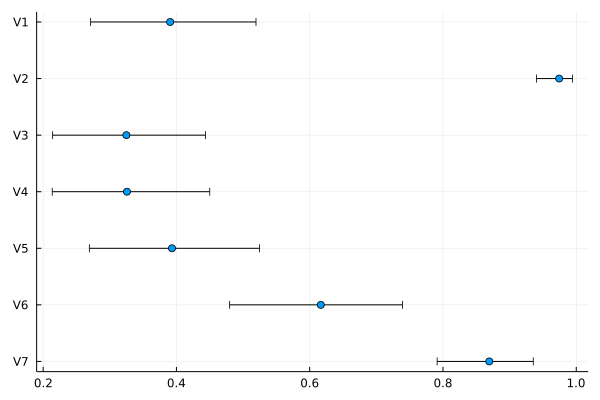

In [13]:
p_left = DataFrame(map(i -> "V$i" => logistic.(m11_4_df[:,"a[$i]"]), 1:7)...);
coeftab_plot(p_left)

Code 11.13

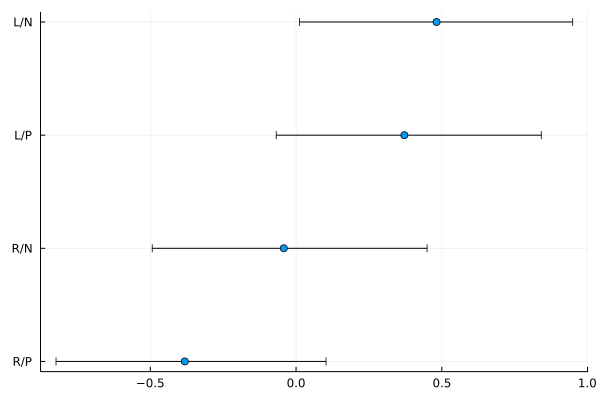

In [14]:
names = ["R/N", "L/N", "R/P", "L/P"]
labs = DataFrame(map(i -> names[i] => m11_4_df[:,"b[$i]"], 1:4)...)
coeftab_plot(labs)

Code 11.14

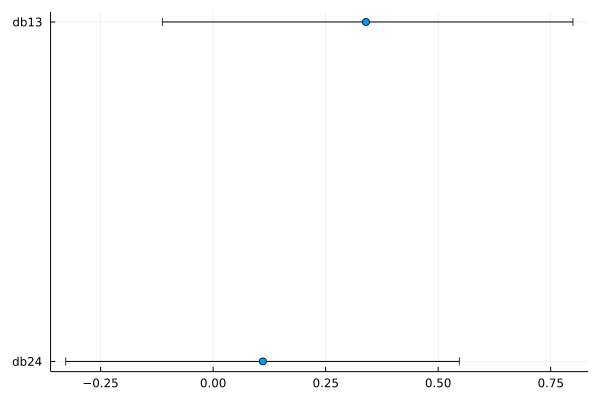

In [15]:
diffs = DataFrame(
    db13=m11_4_df."b[1]" .- m11_4_df."b[3]",
    db24=m11_4_df."b[2]" .- m11_4_df."b[4]",
)
coeftab_plot(diffs)

Code 11.15

In [16]:
gd = groupby(d, [:actor, :treatment])
c = combine(gd, :pulled_left => mean => :val)
pl = unstack(c, :actor, :treatment, :val)
pl[1,:]

,actor,1,2,3,4
,Int64,Float64?,Float64?,Float64?,Float64?
1,1,0.333333,0.5,0.277778,0.555556


Code 11.16

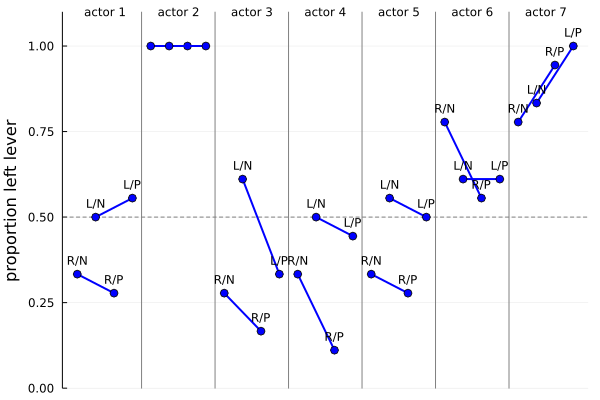

In [17]:
names = ["R/N", "L/N", "R/P", "L/P"]
p = plot(ylims=(0, 1.1), ylab="proportion left lever", showaxis=:y, xticks=false)
hline!([0.5], c=:gray, s=:dash)
for actor in 1:7
    ofs = (actor-1)*4
    actor > 1 && vline!([ofs+0.5], c=:gray)
    plot!([ofs+1,ofs+3], collect(pl[actor,["1","3"]]), lw=2, m=:o, c=:blue)
    plot!([ofs+2,ofs+4], collect(pl[actor,["2","4"]]), lw=2, m=:o, c=:blue)
    anns = [
        (ofs+idx, pl[actor,string(idx)]+.04, (name, 8))
        for (idx,name) ∈ enumerate(names)
    ]
    actor != 2 && annotate!(anns)
end

annotate!([
    (2.5 + (idx-1)*4, 1.1, ("actor $idx", 8))
    for idx ∈ 1:7
])
p

Code 11.17

In [18]:
l_fun = (r, (ai, bi)) -> logistic(get(r, "a[$ai]", missing) + get(r, "b[$bi]", missing))
p_post = link(m11_4_df, l_fun, Iterators.product(1:7, 1:4))
p_μ = map(mean, p_post)
p_ci = map(PI, p_post);

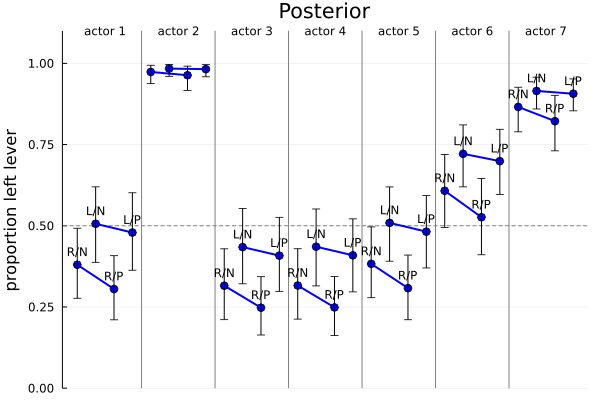

In [19]:
# visualize mean and cred intervals of posterior distribution

# compute relative intervals 
rel_ci = map(idx -> (p_μ[idx]-p_ci[idx][1], p_ci[idx][2]-p_μ[idx]), CartesianIndices(p_ci))

names = ["R/N", "L/N", "R/P", "L/P"]
p = plot(ylims=(0, 1.1), ylab="proportion left lever", title="Posterior", showaxis=:y, xticks=false)
hline!([0.5], c=:gray, s=:dash)
for actor in 1:7
    ofs = (actor-1)*4
    actor > 1 && vline!([ofs+0.5], c=:gray)
    err = [rel_ci[actor,1], rel_ci[actor,3]]
    plot!([ofs+1,ofs+3], collect(p_μ[actor,[1,3]]), err=err, lw=2, m=:o, c=:blue)
    err = [rel_ci[actor,2], rel_ci[actor,4]]    
    plot!([ofs+2,ofs+4], collect(p_μ[actor,[2,4]]), err=err, lw=2, m=:o, c=:blue)
    anns = [
        (ofs+idx, p_μ[actor,idx]+.04, (name, 8))
        for (idx,name) ∈ enumerate(names)
    ]
    actor != 2 && annotate!(anns)
end

annotate!([
    (2.5 + (idx-1)*4, 1.1, ("actor $idx", 8))
    for idx ∈ 1:7
])
p

Code 11.18

In [20]:
d.side = d.prosoc_left .+ 1
d.cond = d.condition .+ 1;

Code 11.19

In [21]:
@model function m11_5(actor, side, cond, pulled_left)
    act_levels = length(levels(actor))
    a ~ MvNormal(zeros(act_levels), 1.5)
    side_levels = length(levels(side))
    bs ~ MvNormal(zeros(side_levels), 0.5)    
    cond_levels = length(levels(cond))
    bc ~ MvNormal(zeros(cond_levels), 0.5)
    
    p = @. logistic(a[actor] + bs[side] + bc[cond])
    for i ∈ eachindex(pulled_left)
        pulled_left[i] ~ Binomial(1, p[i])
    end
end

m11_5_chain = sample(m11_5(d.actor, d.side, d.cond, d.pulled_left), NUTS(), 1000)
m11_5_df = DataFrame(m11_5_chain);

Code 11.20

In [22]:
l_fun = (r, (ai, bi, pull_left)) -> begin
    p = logistic(get(r, "a[$ai]", 0) + get(r, "b[$bi]", 0))
    binomlogpdf(1, p, pull_left)
end

m11_4_ll = link(m11_4_df, l_fun, zip(d.actor, d.treatment, d.pulled_left))
m11_4_ll = hcat(m11_4_ll...);

l_fun = (r, (ai, si, ci, pull_left)) -> begin
    p = logistic(get(r, "a[$ai]", 0) + get(r, "bs[$si]", 0) + get(r, "bc[$ci]", 0))
    binomlogpdf(1, p, pull_left)
end

m11_5_ll = link(m11_5_df, l_fun, zip(d.actor, d.side, d.cond, d.pulled_left))
m11_5_ll = hcat(m11_5_ll...);

compare([m11_5_ll, m11_4_ll], :psis, mnames=["m5", "m4"])

,models,PSIS,lppd,SE,dPSIS,dSE,pPSIS,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m5,529.2,515.35,18.95,0.0,0.0,7.42,0.73
2,m4,531.2,515.29,18.91,2.0,1.26,8.53,0.27


Code 11.21 and 11.22 were omitted, as they are stan-specific

Code 11.23

In [23]:
mean(@. exp(m11_4_df."b[4]" - m11_4_df."b[2]"))

0.929122563241465

Code 11.24

In [24]:
gb = groupby(d, [:treatment, :actor, :side, :cond])
d_aggregated = combine(gb, :pulled_left => sum => :left_pulls)
first(d_aggregated, 8)

,treatment,actor,side,cond,left_pulls
,Int64,Int64,Int64,Int64,Int64
1,1,1,1,1,6
2,1,2,1,1,18
3,1,3,1,1,5
4,1,4,1,1,6
5,1,5,1,1,6
6,1,6,1,1,14
7,1,7,1,1,14
8,2,1,2,1,9


Code 11.25

In [25]:
@model function m11_6(actor, treatment, left_pulls)
    act_levels = length(levels(actor))
    a ~ MvNormal(zeros(act_levels), 1.5)
    treat_levels = length(levels(treatment))
    b ~ MvNormal(zeros(treat_levels), 0.5)
    
    p = @. logistic(a[actor] + b[treatment])
    for i ∈ eachindex(left_pulls)
        left_pulls[i] ~ Binomial(18, p[i])
    end
end

m11_6_chain = sample(m11_6(d_aggregated.actor, d_aggregated.treatment, d_aggregated.left_pulls), NUTS(), 1000)
m11_6_df = DataFrame(m11_6_chain);

Code 11.26

In [26]:
l_fun = (r, (ai, bi, left_pulls)) -> begin
    p = logistic(get(r, "a[$ai]", 0) + get(r, "b[$bi]", 0))
    binomlogpdf(18, p, left_pulls)
end

m11_6_ll = link(m11_6_df, l_fun, zip(d_aggregated.actor, d_aggregated.treatment, d_aggregated.left_pulls))
m11_6_ll = hcat(m11_6_ll...)

try
    compare([m11_6_ll, m11_4_ll], :psis, mnames=["m6", "m4"])
catch e
    println(e)
end

DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 28 and 504")


Code 11.27

In [27]:
(
    -2*binomlogpdf(9, 0.2, 6),
    -2*sum(binomlogpdf.(1, 0.2, [1,1,1,1,1,1,0,0,0]))
)

(11.79048265940783, 20.652116257094466)

Code 11.28

In [28]:
d = DataFrame(CSV.File("data/UCBadmit.csv", skipto=2, 
        header=[:id, :dept, :gender, :admit, :reject, :applications]))

,id,dept,gender,admit,reject,applications
,Int64,String1,String7,Int64,Int64,Int64
1,1,A,male,512,313,825
2,2,A,female,89,19,108
3,3,B,male,353,207,560
4,4,B,female,17,8,25
5,5,C,male,120,205,325
6,6,C,female,202,391,593
7,7,D,male,138,279,417
8,8,D,female,131,244,375
9,9,E,male,53,138,191


Code 11.29

In [29]:
dat = d[!, [:admit, :applications]]
dat.gid = @. ifelse(d.gender == "male", 1, 2)

@model function m11_7(admit, applications, gid)
    a ~ MvNormal([0, 0], 1.5)
    p = @. logistic(a[gid])
    for i ∈ eachindex(applications)
        admit[i] ~ Binomial(applications[i], p[i])
    end
end

m11_7_chain = sample(m11_7(dat.admit, dat.applications, dat.gid), NUTS(), 1000)
m11_7_df = DataFrame(m11_7_chain)
precis(m11_7_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│  a[1] │ -0.2216  0.0383  -0.2832  -0.2213  -0.1563  ▁▁▂▄▇██▇▄▂▁▁ │
│  a[2] │ -0.8306  0.0508  -0.9126  -0.8313  -0.7488       ▁▂▆█▅▂▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 11.30

In [30]:
diff_a = m11_7_df."a[1]" .- m11_7_df."a[2]"
diff_p = @. logistic(m11_7_df."a[1]") - logistic(m11_7_df."a[2]")

precis(DataFrame(diff_a=diff_a, diff_p=diff_p))

┌────────┬────────────────────────────────────────────────────┐
│  param │   mean     std    5.5%     50%   94.5%   histogram │
├────────┼────────────────────────────────────────────────────┤
│ diff_a │  0.609  0.0635  0.5079  0.6094   0.711   ▁▁▂▄██▆▂▁ │
│ diff_p │ 0.1412  0.0143  0.1186  0.1412  0.1641  ▁▁▂▅██▆▂▁▁ │
└────────┴────────────────────────────────────────────────────┘


Code 11.31

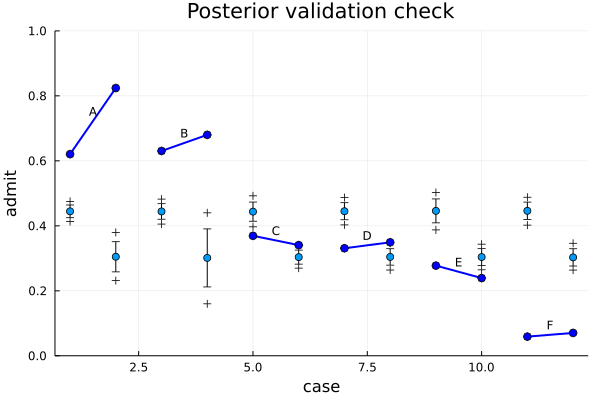

In [35]:
Random.seed!(1)

fun = (r, (apps, gid)) -> begin
    p = logistic(get(r, "a[$gid]", 0))
    rand(Binomial(apps, p))
end

admit_pred = link(m11_7_df, fun, zip(dat.applications, dat.gid))
admit_rate = @. admit_pred ./ dat.applications

# plot
xrange = 1:12
p = plot(yrange=(0, 1), title="Posterior validation check", xlab="case", ylab="admit")
scatter!(xrange, mean.(admit_rate), yerr=std.(admit_rate))
pi_rate = PI.(admit_rate)
scatter!(xrange, first.(pi_rate), shape=:cross, c=:black)
scatter!(xrange, last.(pi_rate), shape=:cross, c=:black)

dat_rates = dat.admit ./ dat.applications

for idx in 1:2:12
    r = [dat_rates[idx], dat_rates[idx+1]]
    plot!([idx, idx+1], r, mark=:o, lw=2, c=:blue)
    annotate!([(idx+0.5, mean(r)+0.03, (d.dept[idx], 8))])
end
p

Code 11.32

In [32]:
dat.dept_id = reshape(hcat(1:6, 1:6)', 12)

@model function m11_8(admit, applications, gid, dept_id)
    a ~ MvNormal([0, 0], 1.5)
    delta ~ MvNormal(zeros(6), 1.5)
    p = @. logistic(a[gid] + delta[dept_id])
    for i ∈ eachindex(applications)
        admit[i] ~ Binomial(applications[i], p[i])
    end
end

m11_8_chain = sample(m11_8(dat.admit, dat.applications, dat.gid, dat.dept_id), NUTS(), 1000)
m11_8_df = DataFrame(m11_8_chain)
precis(m11_8_df)

┌──────────┬───────────────────────────────────────────────────────┐
│    param │    mean     std     5.5%      50%    94.5%  histogram │
├──────────┼───────────────────────────────────────────────────────┤
│     a[1] │ -0.5904  0.4753  -1.4541  -0.5667   0.0759    ▁▂▃██▂▁ │
│     a[2] │ -0.4937  0.4728  -1.3508   -0.464   0.1564    ▁▁▃▇█▃▁ │
│ delta[1] │  1.1706  0.4761   0.4834   1.1412   2.0253    ▁▂▇█▄▂▁ │
│ delta[2] │  1.1285  0.4827   0.4516   1.0966   1.9931    ▁▂██▄▂▁ │
│ delta[3] │ -0.0858   0.477  -0.7715  -0.1229   0.7755    ▁▄█▆▂▁▁ │
│ delta[4] │  -0.121  0.4755  -0.7791  -0.1486   0.7583     ▁▄█▅▂▁ │
│ delta[5] │ -0.5609   0.479  -1.2411  -0.5933   0.3125     ▁▄█▇▂▁ │
│ delta[6] │  -2.125  0.4952  -2.8541  -2.1313  -1.2774     ▁▅█▆▂▁ │
└──────────┴───────────────────────────────────────────────────────┘


Code 11.33

In [33]:
diff_a = m11_8_df."a[1]" .- m11_8_df."a[2]"
diff_p = logistic.(m11_8_df."a[1]") .- logistic.(m11_8_df."a[2]")
precis(DataFrame(diff_a=diff_a, diff_p=diff_p))

┌────────┬─────────────────────────────────────────────────────────┐
│  param │    mean     std     5.5%      50%   94.5%     histogram │
├────────┼─────────────────────────────────────────────────────────┤
│ diff_a │ -0.0967  0.0761  -0.2167  -0.0965  0.0309    ▁▁▂▆██▆▃▁▁ │
│ diff_p │ -0.0216  0.0175  -0.0495  -0.0214  0.0065  ▁▁▂▄▆██▆▃▂▁▁ │
└────────┴─────────────────────────────────────────────────────────┘


Code 11.34

In [34]:
gb = groupby(d, :dept)
fun = (as,gs) -> [(gender=g, a_ratio=a/sum(as)) for (a,g) in zip(as,gs)]
c = combine(gb, [:applications, :gender] => fun => AsTable)
unstack(c, :gender, :dept, :a_ratio)

,gender,A,B,C,D,E,F
,String7,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,male,0.884244,0.957265,0.354031,0.526515,0.327055,0.522409
2,female,0.115756,0.042735,0.645969,0.473485,0.672945,0.477591


# 11.2 Poisson regression